# Generate questions

This notebook outlines the steps undertook to generate the questions to serve as datapoints to create question-result pairs for modeling & evaluation under the QA task formation.

This is essentially a copy of the 2a notebook, except I tuned the system_prompt to now generate a question instead of a statement.

# Import libraries

In [1]:
#%pip install tiktoken -q
#%pip install openai -q

import time
import json

import numpy as np
import pandas as pd

import tiktoken
from openai import OpenAI

# Global variables

In [2]:
API_KEY = "YOUR_API_KEY"
SYSTEM_PROMPT = '''
Given a list of case law opinions, generate two search queries for each opinion, both queries should be in the form of questions. 
The 'relevant' search query should satisfy that the opinion is relevant for the query and the opinion should be sufficient to answer the query, 
while the 'irrelevant' search query should be not relevant to the opinion and the opinion should not be sufficient to answer the query. Return the queries in a form of a json. 
Here is an example: 
input = {'id 1': 'opinion 1', 
         'id 2': 'opinion 2', 
         'id 3': 'opinion 3'}, 
output = {'id 1': {'relevant': 'relevant 1', 'irrelevant': 'irrelevant 1'}, 
          'id 2': {'relevant': 'relevant 2', 'irrelevant': 'irrelevant 2'},
          'id 3': {'relevant': 'relevant 3', 'irrelevant': 'irrelevant 3'}}
'''

# Helper functions

In [3]:
# from openai cookbook: https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken
def num_tokens_from_messages(system_prompt, user_prompt, model="gpt-4o-mini-2024-07-18"):
    """Return the number of tokens used by a list of messages."""

    messages = [{"role": "system", "content": f"{system_prompt}"},
                {"role": "user", "content": f"{user_prompt}"}]
    
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using o200k_base encoding.")
        encoding = tiktoken.get_encoding("o200k_base")
    if model in {
        "gpt-3.5-turbo-0125",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        "gpt-4o-mini-2024-07-18",
        "gpt-4o-2024-08-06"
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif "gpt-3.5-turbo" in model:
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0125.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0125")
    elif "gpt-4o-mini" in model:
        print("Warning: gpt-4o-mini may update over time. Returning num tokens assuming gpt-4o-mini-2024-07-18.")
        return num_tokens_from_messages(messages, model="gpt-4o-mini-2024-07-18")
    elif "gpt-4o" in model:
        print("Warning: gpt-4o and gpt-4o-mini may update over time. Returning num tokens assuming gpt-4o-2024-08-06.")
        return num_tokens_from_messages(messages, model="gpt-4o-2024-08-06")
    elif "gpt-4" in model:
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

In [4]:
f"number of tokens used by system prompt: {num_tokens_from_messages(' '.join(SYSTEM_PROMPT.split()), '')}"

'number of tokens used by system prompt: 219'

In [5]:
def group_opinions_by_tokens(df, 
                             system_prompt='',
                             max_tokens=40000,
                             max_size=6):
    batches = {} 
    current_batch = []
    current_batch_ids = []
    current_token_count = 0

    for opinion_id, opinion in zip(df["opinion_id"], df["opinion"]): 
        new_batch = current_batch + [opinion]  # Add new opinion to batch
        tokens = num_tokens_from_messages(system_prompt, new_batch)

        # If adding this opinion exceeds max_tokens or max_size, start a new batch
        if tokens > max_tokens or len(new_batch) > max_size:
            if current_batch:  # Avoid adding empty batch
                batches[tuple(current_batch_ids)] = [current_batch, current_token_count]
            # Start new batch with the current opinion
            current_batch = [opinion]  
            current_batch_ids = [opinion_id]
            current_token_count = num_tokens_from_messages(system_prompt, current_batch)

        else:
            current_batch.append(opinion)
            current_batch_ids.append(opinion_id)
            current_token_count = tokens

    # Append the last batch if it contains any opinions
    if current_batch:
        current_token_count = num_tokens_from_messages(system_prompt, current_batch)
        batches[tuple(current_batch_ids)] = [current_batch, current_token_count]

    return batches

In [6]:
def gpt_completion(api_key,
                   system_prompt,
                   user_prompt, 
                   model="gpt-4o-mini"):
    
    client = OpenAI(api_key=api_key)
    completion = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "system", "content": f"{system_prompt}"},
                  {"role": "user","content": f"{user_prompt}"}]
    )
    
    result = completion.choices[0].message.content
    return result

# Load the data

In [28]:
df = pd.read_csv("outputs/1b.opinions_cleaned.csv")
df = df[["opinion_id", "opinion"]]
df.head()

,opinion_id,opinion
0,444587,"748 F.2d 972 UNITED STATES of America, Plainti..."
1,9410469,Nebraska Supreme Court Online Library www.nebr...
2,714663,78 F.3d 599 U.S. v. Johnston ** NO. 94-2273 Un...
3,2729050,"Pursuant to Ind. Appellate Rule 65(D), this Me..."
4,692963,51 F.3d 288 311 U.S.App.D.C. 145 UNITED STATES...


# Count the number of gpt-4o-mini tokens for each opinion

In [29]:
df['opinion_4omini_tokens'] = df["opinion"].apply(lambda x: num_tokens_from_messages("", x))
df['opinion_4omini_tokens'].describe()

count      953.000000
mean      2235.194124
std       3089.424231
min         14.000000
25%        216.000000
50%       1209.000000
75%       2941.000000
max      30190.000000
Name: opinion_4omini_tokens, dtype: float64

<Axes: >

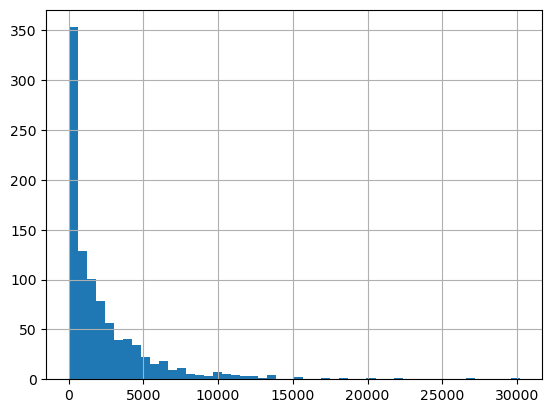

In [9]:
df['opinion_4omini_tokens'].hist(bins=50)

# Generate batches for API requests

This section is much cleaner than 2a notebook, since I know the script works and figured out the rate limit issue. The system prompt for this set was slightly longer than in 2a but the cost was comparable. I ended up using <$1 to generate the datasets for both IR and QA task formation.

The code block was ran twice because occassionally an opinion is missing in the request response and therefore needs to be sent again.

In [32]:
todo = df[df["input_opinion"].isna()]
len(todo)

16

In [33]:
batches = group_opinions_by_tokens(todo, max_tokens=60000, max_size=6)
len(batches.keys())

3

In [34]:
for ids, [opinions, num_tokens] in batches.items():
    print(ids)
    print(num_tokens)

(6331009, 6550068, 7044144, 8836719, 1771285, 1359066)
16763
(2654943, 1813170, 1186774, 2898711, 3996688, 4252778)
26351
(4361755, 1512907, 8211259, 577210)
9426


In [35]:
%%time

counter = 1
results = {}
errors = {}
for ids, [opinions, num_tokens] in batches.items():
    print(f"batch {counter} started...")
    
    try:
        result = gpt_completion(API_KEY, ' '.join(SYSTEM_PROMPT.split()), {ids[i]: opinions[i] for i in range(len(ids))})
        try:
            loaded_result = json.loads(result)
        except:
            loaded_result = result
        
        results[ids] = {
            "opinions": opinions,
            "num_tokens": num_tokens,
            "result": loaded_result
        }
        print(f"batch {counter} completed...")
    except Exception as e:
        errors[ids] = f"{e}"
        print(f"batch {counter} {e}...")
    
    counter += 1
    time.sleep(20)

batch 1 started...
batch 1 completed...
batch 2 started...
batch 2 completed...
batch 3 started...
batch 3 completed...
CPU times: user 167 ms, sys: 43 ms, total: 210 ms
Wall time: 1min 14s


In [36]:
rows = []
issues = []
for ids, values in results.items():
    opinions = values['opinions']
    result = values['result']
    
    for opinion, id_ in zip(opinions, ids):
        try:
            rows.append({
                'opinion_id': id_,
                'input_opinion': opinion,
                'relevant_query_qstn': result[str(id_)]['relevant'],
                'irrelevant_query_qstn': result[str(id_)]['irrelevant']
            })
        except:
            issues.append(ids)

In [37]:
results_df = pd.DataFrame(rows)
results_df

,opinion_id,input_opinion,relevant_query_qstn,irrelevant_query_qstn
0,6331009,Case: 20-61182 Document: 00516278598 Page: 1 D...,What were the reasons the Fifth Circuit denied...,What is the history of immigration law in the ...
1,6550068,"Lawson Cloninger, Judge. Appellant Kenneth Tu...",What were the grounds for Kenneth Tucker's app...,What are the steps involved in filing for divo...
2,7044144,"Bicknell, C. The city of Greencastle had an o...",How did the city of Greencastle handle the imp...,What are the current laws regarding environmen...
3,8836719,"Shipman, J. This is a bill in equity, based u...",What factors did the court consider in decidin...,What is the process for filing a patent in the...
4,1771285,"452 S.W.2d 490 (1970) Wayne Edward HALL, Appel...",What was the basis for revoking Wayne Edward H...,What are the requirements to obtain a driver's...
5,1359066,703 P.2d 699 (1985) 108 Idaho 935 Marcilena SH...,What criteria did the Idaho Supreme Court use ...,What are the educational requirements for beco...
6,2654943,IN THE SUPREME COURT OF THE STATE OF ARIZONA ...,How does Arizona law protect pension benefits ...,What is the process for electing officials in ...
7,1813170,929 F. Supp. 172 (1996) NEW YORK CITY DEPARTME...,What are the legal grounds for a city to claim...,What are the historical landmarks in New York ...
8,1186774,"405 P.2d 939 (1965) Guy TANNER, Lyal E. Quinby...",What legal standing do residents have to chall...,What is the history of the city of Boulder?
9,2898711,NO. 07-08-0356-CR IN THE COURT OF APPEALS FOR...,What constitutes a valid claim for disability ...,What are the social implications of insurance ...


In [38]:
df = df.merge(results_df, how="left", on="opinion_id", suffixes=('', '_results'))

# Replace NaN values in df with corresponding values from results_df
for column in results_df.columns:
    if column != "opinion_id": 
        df[column] = df[column].fillna(df[column + '_results'])
        df.drop(columns=[column + '_results'], inplace=True)

In [39]:
done = df[~df["relevant_query_qstn"].isna()]
len(done)

953

# Save the resulting df with generated queries

In [41]:
df.to_csv("outputs/2b.questions_generated.csv", index=False)